Задача 3. Заданы два временных ряда. Предложить алгоритм выравнивания, который ищет путь наименьшей стоимости не перебором, а методом градиентного спуска, приближая полиномом (третьей) степени.  
Итак, даны два "похожих" временных ряда.  
$Q = q_1,q_2,...,q_i,...,q_n$  
$C = c_1,c_2,...,c_j,...,c_m$  
Предполагается, что ряд получается из другого посредством преобразования  
$Q=\beta_0C^3+\beta_1C^2+\beta_2C+\beta_3C$  
Расстояние между элементами последовательности определяется следующим образом:  
$d(q_i,c_i)={(q_i-c_i)}^2$  
Путь определяется так:  
$DTW(Q,C)=min\left\{{\displaystyle\sum_{k=1}^{K} {
d(q_i,c_i)}}\right\}$

In [13]:
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.pipeline import make_pipeline
#from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xlrd

В качестве похожих временных рядов возьмем показатели датчика Air Quality
https://archive.ics.uci.edu/ml/datasets/Air+quality

In [14]:
workbook = xlrd.open_workbook("C:\\Users\\Username\\Desktop\\AirQualityUCI\\AirQualityUCI.xlsx","rb")
sheets = workbook.sheet_names()
X = [] #NMHC(GT)
Y = [] #PT08.S2(NHMC)
rownum = 1
for sheet_name in sheets:
    sh = workbook.sheet_by_name(sheet_name)
    for rownum in range(sh.nrows):
        row_valaues = sh.row_values(rownum)
        X.append(row_valaues[4])
        Y.append(row_valaues[6])
X=X[1:1000]
Y=Y[1:1000]

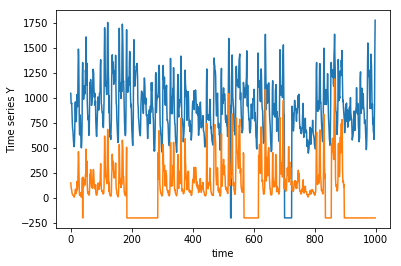

In [15]:
XG = np.arange(0,999)
#fig= plt.figure()
#plt.title("")
plt.xlabel("time")
plt.ylabel("Time series Y")
plt.plot( XG,Y)
plt.plot(XG, X)
#plt.savefig('TimeSeriesY.png', dpi=fig.dpi*3)
plt.show()

Отложим далее по осям временные ряды. Как видно, между ними есть корреляция

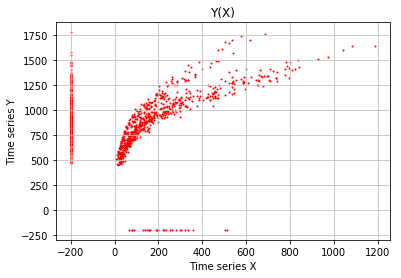

In [16]:
#fig= plt.figure()
plt.title("Y(X)")
plt.xlabel("Time series X")
plt.ylabel("Time series Y")
plt.scatter( X,Y, edgecolors='r', s=1)
plt.grid(True, linestyle='-', color='0.75')
#plt.savefig('Y(X)', dpi=fig.dpi*3)
plt.show()

Иногда несколько элементов ряда подряд принимают значение -200. Предполагая, что такие показания обусловлены шумом или неисправностями прибора, удалим их из временных рядов

In [17]:
Xwithout = [] #временные ряды без "неправильных" значений
Ywithout = [] 
i=0
list.clear(Xwithout)
list.clear(Ywithout)
for i in range(999):
    if X[i] > -200 and Y[i] > -200:
        Xwithout.append(X[i])
        Ywithout.append(Y[i])
        

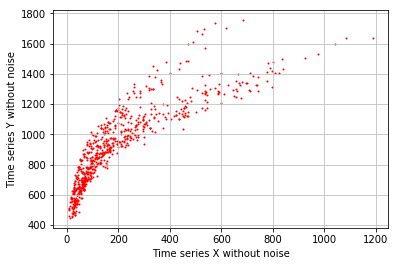

In [18]:
fig= plt.figure()
#plt.title("Y(X) without noise")
plt.xlabel("Time series X without noise")
plt.ylabel("Time series Y without noise")
plt.scatter( Xwithout,Ywithout, edgecolors='r', s=1)
plt.grid(True, linestyle='-', color='0.75')
#plt.savefig('Y(X)withoutNoise.png', dpi=fig.dpi*3)
plt.show()

Для предварительного анализа используем функцию для аппроксимации полиномом. 

[ 2.45727328e-06 -4.79918692e-03  3.33887172e+00  5.19242484e+02]


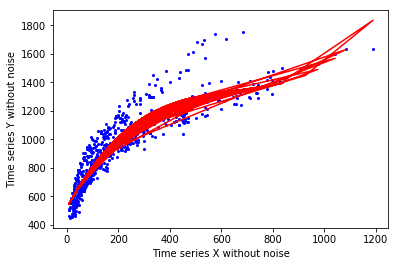

In [19]:
coefs = np.polyfit(Xwithout, Ywithout, 3)
print(coefs)
p = np.poly1d(coefs)
fig= plt.figure()
#plt.title("Y(X) without noise fitting")
plt.xlabel("Time series X without noise")
plt.ylabel("Time series Y without noise")
plt.plot(Xwithout, Ywithout, "bo", markersize= 2)
plt.plot(Xwithout, p(Xwithout), "r-") #p(X) evaluates the polynomial at X
#plt.savefig('Y(X)withoutNoiseFitting.png', dpi=fig.dpi*3)
plt.show()

Будем тренировать на 350 элементах, тестировать на оставшихся 350

In [20]:
X_train, Y_train,X_test,Y_test = [], [],[],[]
i= 0
for i in range(len(Xwithout)//2):
    X_train.append([])
    X_train[i].append(Xwithout[i])
    X_train[i].append(np.power(Xwithout[i],2))
    X_train[i].append(np.power(Xwithout[i],3))
    X_test.append([])
    X_test[i].append(Xwithout[i+len(Xwithout)//2])
    X_test[i].append(np.power(Xwithout[i+len(Xwithout)//2],2))
    X_test[i].append(np.power(Xwithout[i+len(Xwithout)//2],3))
    Y_train.append(Ywithout[i])
    Y_test.append(Ywithout[i+len(Xwithout)//2])

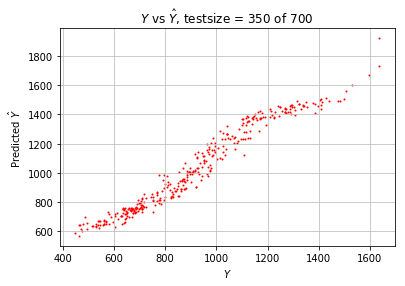

In [21]:
lm = linear_model.LinearRegression()
lm.fit(X_train, Y_train)
Y_pred = lm.predict(X_test)
fig= plt.figure()
plt.scatter(Y_test, Y_pred, edgecolors='r', s=1)
plt.xlabel("$Y$")
plt.ylabel("Predicted $\hat{Y}$")
plt.title("$Y$ vs $\hat{Y}$, testsize = 350 of 700")
plt.grid(True, linestyle='-', color='0.75')
plt.savefig('Y vs predicted Y', dpi=fig.dpi*3)

In [22]:
MAE=mean_absolute_error(Y_test, Y_pred)
MSE=mean_squared_error(Y_test, Y_pred)
print('r2 = {}'.format(np.std(Y_test-Y_pred)))
print('MSE = {}'.format(np.sqrt(MSE)))
print('MAE = {}'.format(MAE))

r2 = 66.41185647346799
MSE = 132.6070533157139
MAE = 115.21509385869241


Исследуем зависимость ошибок от глубины тренировочной выборки. Будем варьировать глубину от 350 до 690 из 700

In [23]:
i= 0
MSEarray, MAEarray, STDarray = [],[],[]
for j in range(10,350):
    X_train, Y_train,X_test,Y_test = [],[],[],[]
    for i in range(len(Xwithout)-j):
        X_train.append([])
        X_train[i].append(Xwithout[i])
        X_train[i].append(np.power(Xwithout[i],2))
        X_train[i].append(np.power(Xwithout[i],3))
        Y_train.append(Ywithout[i])
    for i in range(j):
        X_test.append([])
        X_test[i].append(Xwithout[i+len(Xwithout)-j])
        X_test[i].append(np.power(Xwithout[i+len(Xwithout)-j],2))
        X_test[i].append(np.power(Xwithout[i+len(Xwithout)-j],3))
        Y_test.append(Ywithout[i+len(Xwithout)-j])
    lm = linear_model.LinearRegression()
    lm.fit(X_train, Y_train)
    Y_pred = lm.predict(X_test)
    MAEarray.append(mean_absolute_error(Y_test, Y_pred))
    MSEarray.append(np.sqrt(mean_squared_error(Y_test, Y_pred)))
    STDarray.append(np.std(Y_test-Y_pred))

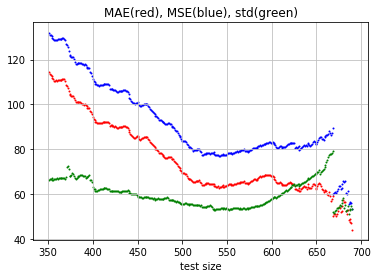

In [24]:
XGG = np.arange(690,350,-1)
fig= plt.figure()
plt.scatter(XGG, MAEarray, edgecolors='r', s=1) # 
plt.scatter(XGG, MSEarray, edgecolors='b', s=1)
plt.scatter(XGG, STDarray, edgecolors='g', s=1)
plt.xlabel("test size")
#plt.ylabel("")
plt.title("MAE(red), MSE(blue), std(green)")
plt.grid(True, linestyle='-', color='0.75')
plt.savefig('dependence on train size.png', dpi=fig.dpi*3)

Исследуем теперь зависимость ошибки от признаков выборки. В прошлые разы использовалось приближение полиномом третьей степени. На этот раз будем приближать полиномами до степени 7 при тренировочной выборке в 550 из 700.

In [25]:
i= 0
X_train, Y_train,X_test,Y_test = [],[],[],[]
for i in range(550):
    X_train.append([])
    X_train[i].append(Xwithout[i])
    X_train[i].append(np.power(Xwithout[i],2))
    X_train[i].append(np.power(Xwithout[i],3))
    X_train[i].append(np.power(Xwithout[i],4))
    X_train[i].append(np.power(Xwithout[i],5))
    X_train[i].append(np.power(Xwithout[i],6))
    X_train[i].append(np.power(Xwithout[i],7))
    Y_train.append(Ywithout[i])
for i in range(149):
    X_test.append([])
    X_test[i].append(Xwithout[i+550])
    X_test[i].append(np.power(Xwithout[i+550],2))
    X_test[i].append(np.power(Xwithout[i+550],3))
    X_test[i].append(np.power(Xwithout[i+550],4))
    X_test[i].append(np.power(Xwithout[i+550],5))
    X_test[i].append(np.power(Xwithout[i+550],6))
    X_test[i].append(np.power(Xwithout[i+550],7))
    Y_test.append(Ywithout[i+550])

In [26]:
MSEarray, MAEarray, STDarray = [],[],[]
for i in range(6,-1,-1):
    lm = linear_model.LinearRegression()
    lm.fit(X_train, Y_train)
    Y_pred = lm.predict(X_test)
    MAEarray.append(mean_absolute_error(Y_test, Y_pred))
    MSEarray.append(np.sqrt(mean_squared_error(Y_test, Y_pred)))
    STDarray.append(np.std(Y_test-Y_pred))
    X_test=np.delete(X_test,i,1)
    X_train=np.delete(X_train,i,1)

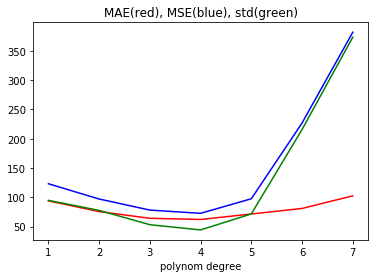

In [27]:
XGG = np.arange(7,0,-1)
fig= plt.figure()
plt.plot(XGG, MAEarray, color='r') # 
plt.plot(XGG, MSEarray, color='b')
plt.plot(XGG, STDarray, color='g')
plt.xlabel("polynom degree")
#plt.ylabel("")
plt.title("MAE(red), MSE(blue), std(green)")
plt.savefig('Dependence on polynom degree.png', dpi=fig.dpi*3)

Как видно, при глубине выборки в 550 из 700 ряды наилучшим образом приближаются полиномом четвертой степени. Полиномы степени ниже 4 приближают недостаточно точно, а при степенях выше 4 происходит переобучение